### Анализ результатов АБ-теста

Необходимо:

* проанализировать АБ тест, проведенный на реальных пользователях Яндекса
* подтвердить или опровергнуть наличие изменений в пользовательском поведении между контрольной (control) и тестовой (exp) группами
* определить характер этих изменений и практическую значимость вводимого изменения
* понять, какая из пользовательских групп более всего проигрывает / выигрывает от тестируемого изменения (локализовать изменение)



Описание данных:

* __userID__: уникальный идентификатор пользователя
* __browser__: браузер, который использовал userID
* __slot__: в каком статусе пользователь участвовал в исследовании (exp = видел измененную страницу, control = видел неизменную страницу)
* __n_clicks__: количество кликов, которые пользоваль совершил за n_queries
* __n_queries__: количество запросов, который совершил userID, пользуясь браузером browser
* __n_nonclk_queries__: количество запросов пользователя, в которых им не было совершено ни одного клика


Не все люди используют только один браузер, поэтому в столбце userID есть повторяющиеся идентификаторы. В предлагаемых данных уникальным является сочетание userID и browser.

In [75]:
import os
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
sns.set()

In [2]:
os.listdir()

['.ipynb_checkpoints', 'ab_browser_test.csv', 'ab_testing_review.ipynb']

In [3]:
df = pd.read_csv(os.listdir()[1])

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 566134 entries, 0 to 566133
Data columns (total 6 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   userID            566134 non-null  int64 
 1   browser           566134 non-null  object
 2   slot              566134 non-null  object
 3   n_clicks          566134 non-null  int64 
 4   n_queries         566134 non-null  int64 
 5   n_nonclk_queries  566134 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 25.9+ MB


In [4]:
df.head()

,userID,browser,slot,n_clicks,n_queries,n_nonclk_queries
0,1,Browser #2,exp,23,32,19
1,3,Browser #4,exp,3,4,2
2,5,Browser #4,exp,29,35,16
3,6,Browser #4,control,12,6,0
4,7,Browser #4,exp,54,68,30


In [5]:
df.describe()

,userID,n_clicks,n_queries,n_nonclk_queries
count,566134.000000,566134.000000,566134.000000,566134.000000
mean,301377.214027,11.431658,10.720524,4.703987
std,175526.333101,20.251494,16.262827,8.109958
min,1.000000,0.000000,1.000000,0.000000
25%,148627.250000,1.000000,2.000000,1.000000
50%,299362.500000,4.000000,5.000000,2.000000
75%,455698.750000,13.000000,13.000000,6.000000
max,603137.000000,863.000000,665.000000,581.000000


1. Основная метрика, на которой мы сосредоточимся в этой работе, — это количество пользовательских кликов на web-странице в зависимости от тестируемого изменения этой страницы.

Посчитайте, насколько в группе exp больше пользовательских кликов по сравнению с группой control в процентах от числа кликов в контрольной группе.

Полученный процент округлите до третьего знака после точки. 

In [13]:
((df[df['slot']=='exp']['n_clicks'].sum()-\
  df[df['slot']=='control']['n_clicks'].sum())/ df[df['slot']=='control']['n_clicks'].sum()
)*100

1.6135689824415809

2. Давайте попробуем посмотреть более внимательно на разницу между двумя группами (control и exp) относительно количества пользовательских кликов.

Для этого постройте с помощью бутстрепа 95% доверительный интервал для средних значений и медиан количества кликов в каждой из двух групп.

In [14]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples

def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [16]:
clicks_exp = df[df['slot']=='exp']['n_clicks'].values
clicks_control = df[df['slot']=='control']['n_clicks'].values

np.random.seed(0)

exp_median_clicks = np.array(list(map(np.median, get_bootstrap_samples(clicks_exp, 1000))))
control_median_clicks = np.array(list(map(np.median, get_bootstrap_samples(clicks_control, 1000))))

exp_mean_clicks = np.array(list(map(np.mean, get_bootstrap_samples(clicks_exp, 1000))))
control_mean_clicks = np.array(list(map(np.mean, get_bootstrap_samples(clicks_control, 1000))))

In [17]:
alpha=0.05

# exp group
print('Median: ', stat_intervals(exp_median_clicks, alpha))
print('Mean: ', stat_intervals(exp_mean_clicks, alpha))

Median:  [5. 5.]
Mean:  [11.50674915 11.65758017]


In [18]:
# control group
print('Median: ', stat_intervals(control_median_clicks, alpha))
print('Mean: ', stat_intervals(control_mean_clicks, alpha))

Median:  [4. 4.]
Mean:  [11.21242374 11.35449133]


In [19]:
diff_value = exp_median_clicks - control_median_clicks
stat_intervals(diff_value, alpha)

array([1., 1.])

In [20]:
diff_value = exp_mean_clicks - control_mean_clicks
stat_intervals(diff_value, alpha)

array([0.19866114, 0.40975645])

In [21]:
df.shape

(566134, 6)

(array([1., 1., 5., 6., 3., 7., 2., 3., 1., 1.]),
 array([11.2362715 , 11.24766793, 11.25906436, 11.27046079, 11.28185722,
        11.29325365, 11.30465008, 11.31604651, 11.32744295, 11.33883938,
        11.35023581]),
 <a list of 10 Patch objects>)

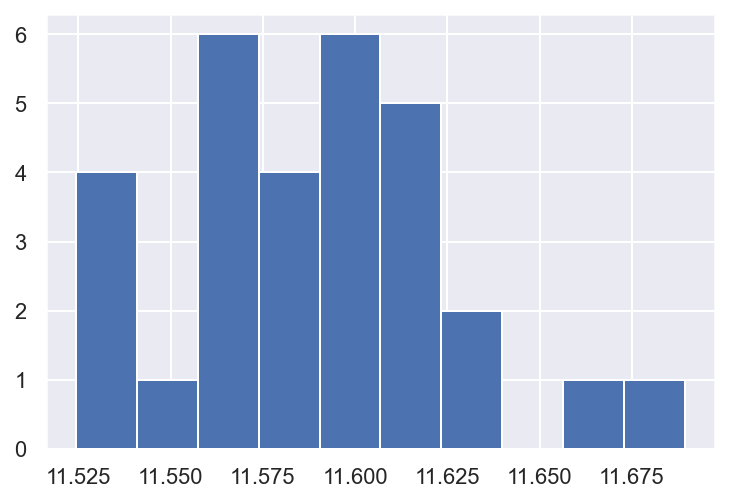

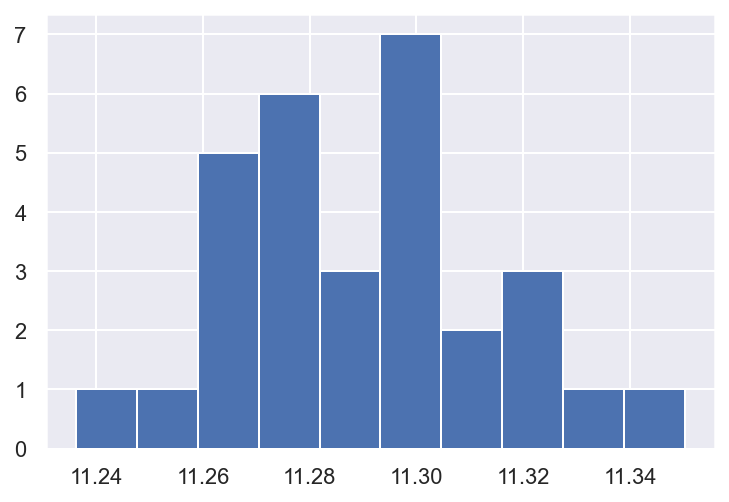

In [29]:
exp_mean_clicks = np.array(list(map(np.mean, get_bootstrap_samples(clicks_exp, 30))))
control_mean_clicks = np.array(list(map(np.mean, get_bootstrap_samples(clicks_control, 30))))
fig=plt.figure()
plt.hist(exp_mean_clicks)
fig=plt.figure()
plt.hist(control_mean_clicks)

(array([1., 2., 1., 1., 7., 4., 2., 6., 4., 2.]),
 array([11.49070246, 11.50791605, 11.52512963, 11.54234321, 11.55955679,
        11.57677037, 11.59398395, 11.61119753, 11.62841111, 11.64562469,
        11.66283827]),
 <a list of 10 Patch objects>)

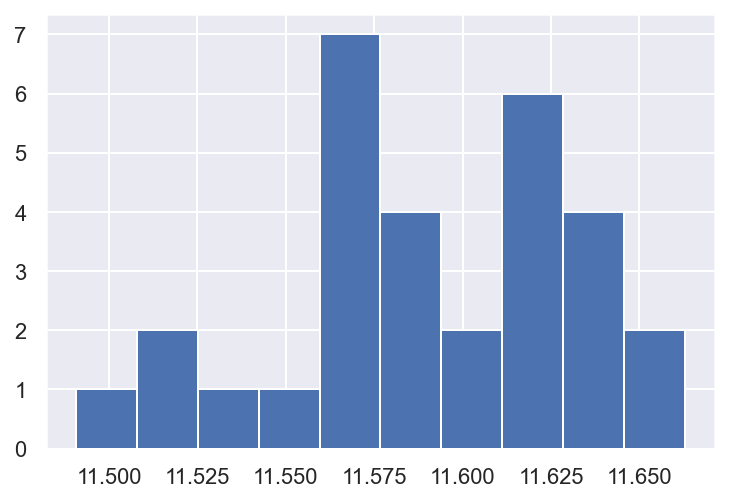

(array([ 3.,  1.,  8., 16., 19., 22., 14.,  9.,  5.,  3.]),
 array([11.19743528, 11.21397485, 11.23051442, 11.24705399, 11.26359355,
        11.28013312, 11.29667269, 11.31321225, 11.32975182, 11.34629139,
        11.36283096]),
 <a list of 10 Patch objects>)

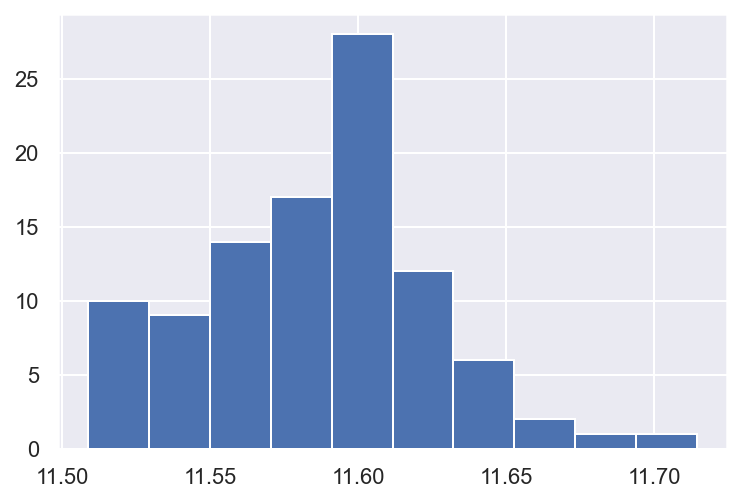

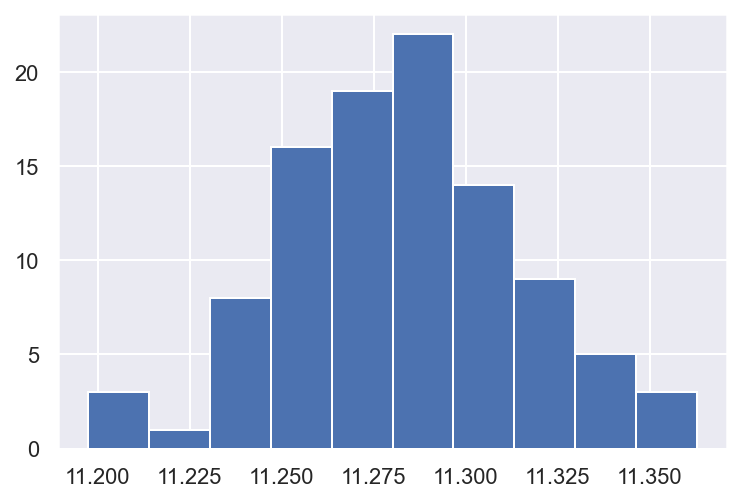

In [30]:
exp_mean_clicks = np.array(list(map(np.mean, get_bootstrap_samples(clicks_exp, 100))))
control_mean_clicks = np.array(list(map(np.mean, get_bootstrap_samples(clicks_control, 100))))
fig=plt.figure()
plt.hist(exp_mean_clicks)
fig=plt.figure()
plt.hist(control_mean_clicks)

(array([  3.,  16.,  37.,  60., 104., 109.,  84.,  54.,  28.,   5.]),
 array([11.17603337, 11.19626363, 11.21649388, 11.23672414, 11.25695439,
        11.27718465, 11.2974149 , 11.31764516, 11.33787541, 11.35810567,
        11.37833592]),
 <a list of 10 Patch objects>)

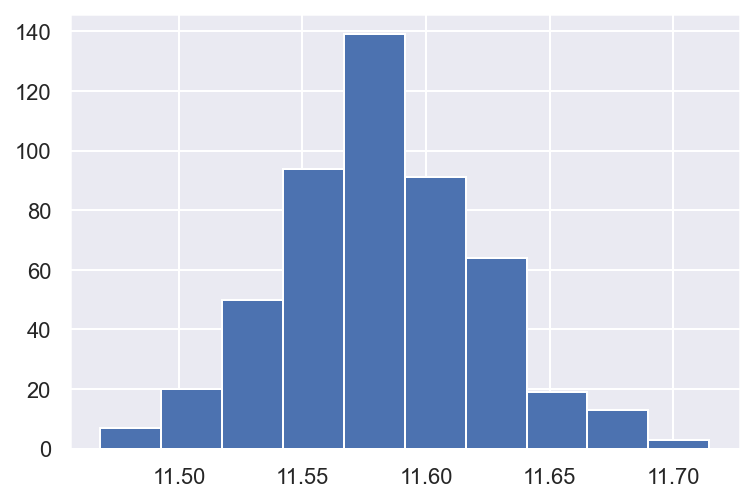

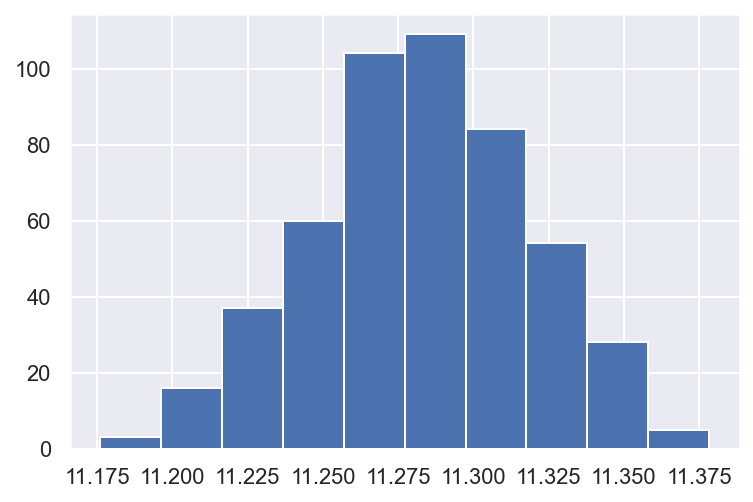

In [31]:
exp_mean_clicks = np.array(list(map(np.mean, get_bootstrap_samples(clicks_exp, 500))))
control_mean_clicks = np.array(list(map(np.mean, get_bootstrap_samples(clicks_control, 500))))
fig=plt.figure()
plt.hist(exp_mean_clicks)
fig=plt.figure()
plt.hist(control_mean_clicks)

(array([  2.,  10.,  54., 128., 238., 287., 182.,  70.,  24.,   5.]),
 array([11.14464038, 11.17069484, 11.1967493 , 11.22280376, 11.24885821,
        11.27491267, 11.30096713, 11.32702158, 11.35307604, 11.3791305 ,
        11.40518496]),
 <a list of 10 Patch objects>)

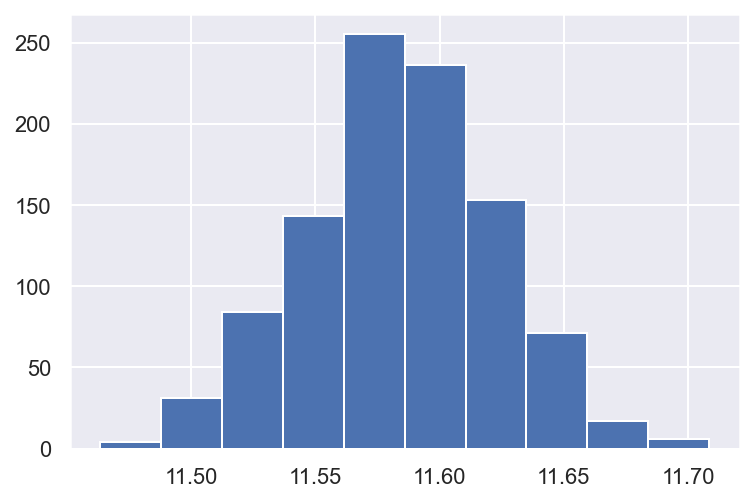

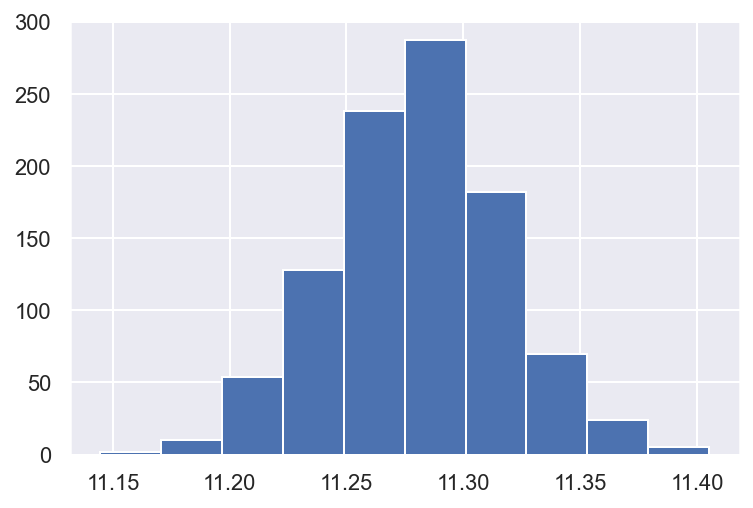

In [32]:
exp_mean_clicks = np.array(list(map(np.mean, get_bootstrap_samples(clicks_exp, 1000))))
control_mean_clicks = np.array(list(map(np.mean, get_bootstrap_samples(clicks_control, 1000))))
fig=plt.figure()
plt.hist(exp_mean_clicks)
fig=plt.figure()
plt.hist(control_mean_clicks)

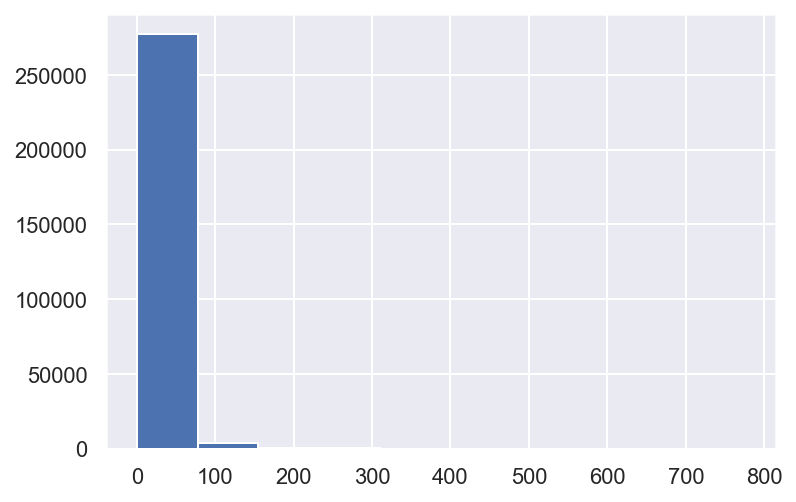

In [35]:
df[df['slot']=='exp']['n_clicks'].hist()

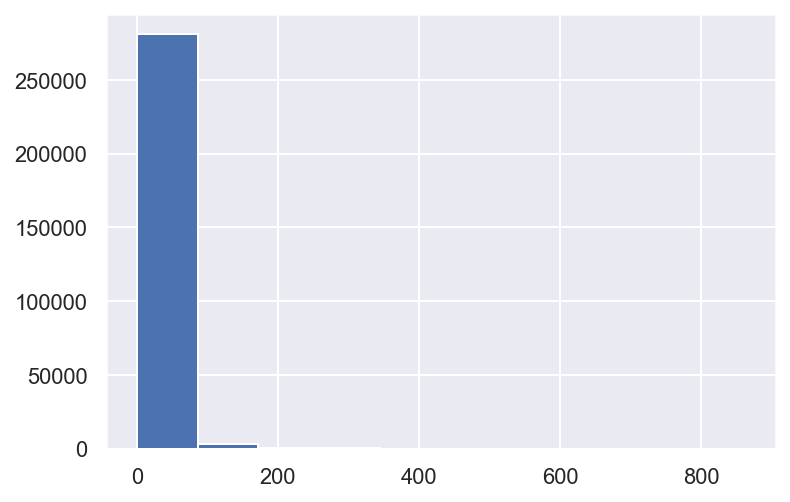

In [36]:
df[df['slot']=='control']['n_clicks'].hist()

Поскольку мы не знаем истинного распределения генеральной совокупности, мы можем применить бутстреп, чтобы понять, как распределены среднее значение и выборочная дисперсия. 

In [37]:
np.random.seed(0)
n_boot_samples = 500


exp_samples = get_bootstrap_samples(clicks_exp, n_boot_samples)
control_samples = get_bootstrap_samples(clicks_exp, n_boot_samples)

exp_mean_clicks = np.array(list(map(np.mean, exp_samples)))
control_mean_clicks = np.array(list(map(np.mean, control_samples)))

In [40]:
exp_samples.shape

(500, 281580)

In [42]:
exp_mean_clicks.shape

(500,)

In [53]:
def repeat_n(x):
    return np.repeat(x, 281580)

In [69]:
def get_sum_squares(samples, mean_array):
    repeated_means = np.array(list(map(repeat_n, mean_array)))
    return ((samples-repeated_means)**2).sum(axis=1)

In [72]:
exp_sum_squares = get_sum_squares(exp_samples, exp_mean_clicks)
control_sum_squares = get_sum_squares(control_samples, control_mean_clicks)

R^2: 0.9973679670567501


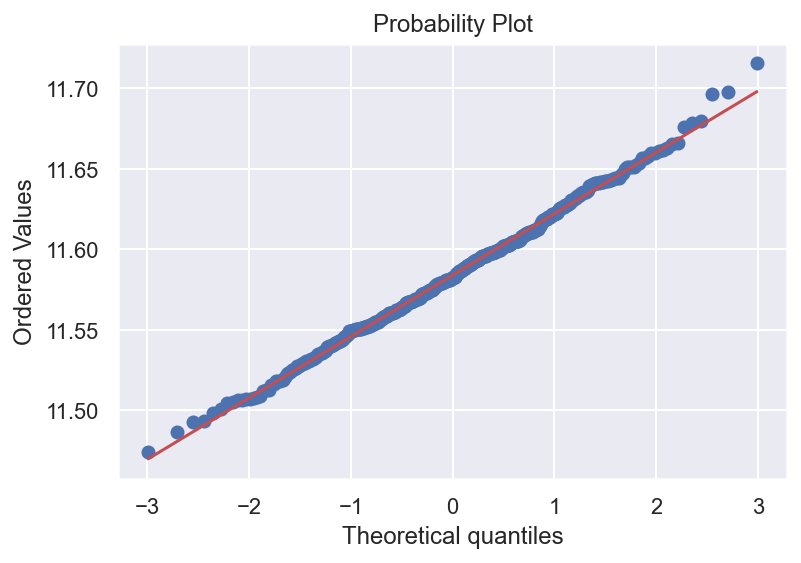

In [90]:
(osm, osr), (slope, intercept, r) = sp.stats.probplot(exp_mean_clicks, dist="norm", fit=True, plot=plt)
print(f'R^2: {r**2}')
plt.show()

R^2: 0.9928765362672958


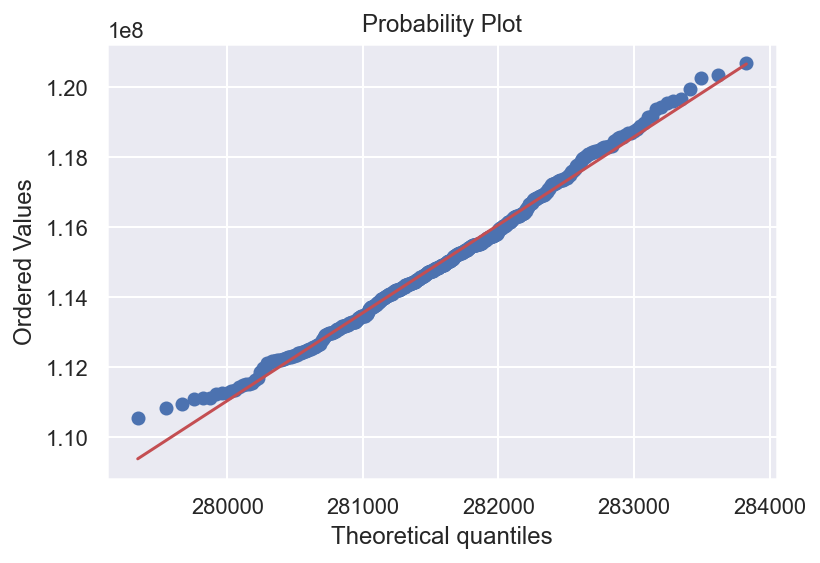

In [91]:
(osm, osr), (slope, intercept, r) = sp.stats.probplot(exp_sum_squares, dist="chi2", fit=True,
                                                      sparams=(n-1), plot=plt)
print(f'R^2: {r**2}')
plt.show()

R^2: 0.9982541545156414


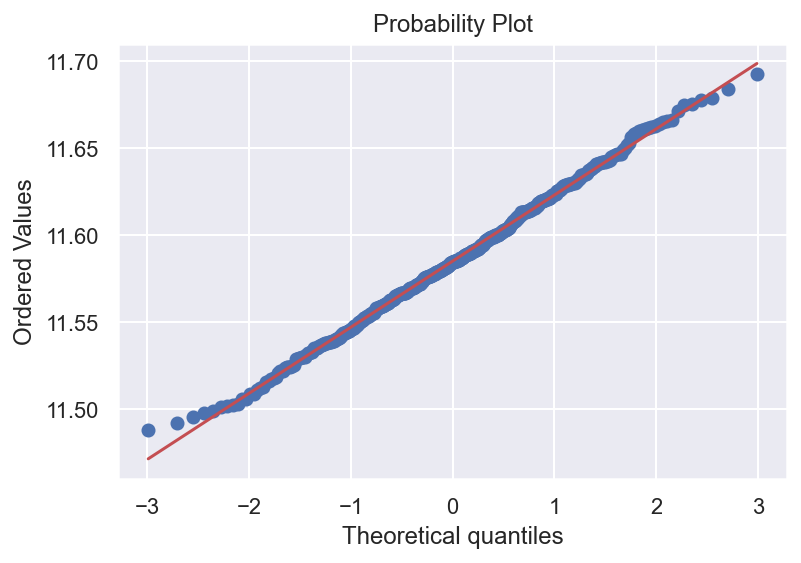

In [92]:
(osm, osr), (slope, intercept, r) = sp.stats.probplot(control_mean_clicks, dist="norm", fit=True, plot=plt)
print(f'R^2: {r**2}')
plt.show()

R^2: 0.9939856021226112


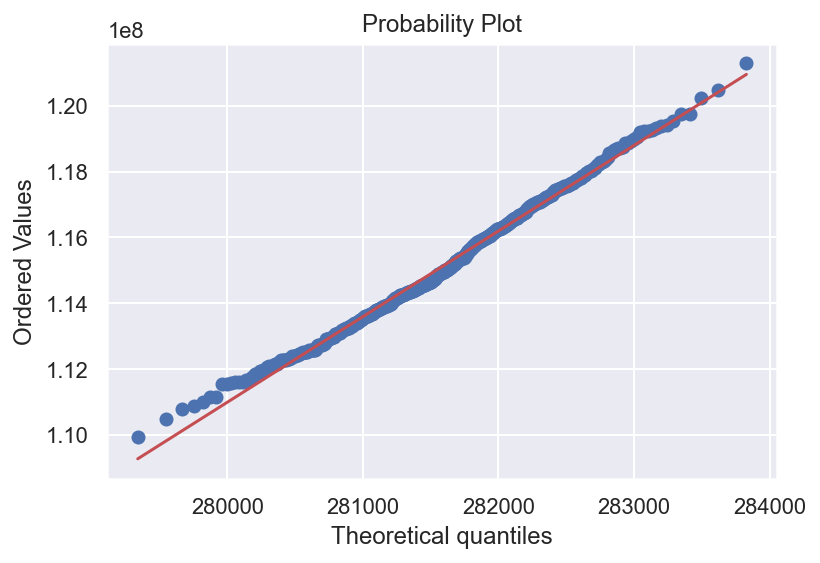

In [93]:
(osm, osr), (slope, intercept, r) = sp.stats.probplot(control_sum_squares, dist="chi2", fit=True, 
                                                      sparams=(n-1), plot=plt)
print(f'R^2: {r**2}')
plt.show()

Разделите выборку на две части, соответствующие control и exp группам. Преобразуйте данные к виду, чтобы каждому пользователю соответствовало суммарное значение его кликов. С помощью критерия Манна-Уитни проверьте гипотезу о равенстве средних. Что можно сказать о получившемся значении достигаемого уровня значимости ? Выберите все правильные ответы

In [99]:
df2 = pd.DataFrame(df.groupby(by=['userID', 'slot'])['n_clicks'].sum())
df2.reset_index(inplace=True)

In [101]:
df2.head()

,userID,slot,n_clicks
0,1,exp,23
1,3,exp,3
2,5,exp,29
3,6,control,12
4,7,exp,54


In [104]:
df2[df2['slot']=='exp'].shape

(281450, 3)

In [105]:
df2[df2['slot']=='control'].shape

(284392, 3)

In [109]:
sp.stats.mannwhitneyu(df2[df2['slot']=='exp']['n_clicks'].values, 
                   df2[df2['slot']=='control']['n_clicks'].values)

MannwhitneyuResult(statistic=38901259929.0, pvalue=4.3471471887604393e-75)

Проверьте, для какого из браузеров наиболее сильно выражено отличие между количеством кликов в контрольной и экспериментальной группах.

Для этого примените для каждого из срезов (по каждому из уникальных значений столбца browser) критерий Манна-Уитни между control и exp группами и сделайте поправку Холма-Бонферрони на множественную проверку с alpha=0.05.

In [112]:
browser_list = df['browser'].unique().tolist()
browser_list

['Browser #2',
 'Browser #4',
 'Browser #14',
 'Browser #17',
 'Browser #20',
 'Browser #22']

In [124]:
p_values = []
for i in browser_list:
    print(i)
    res = sp.stats.mannwhitneyu(df[(df['slot']=='exp')&(df['browser']==i)]['n_clicks'].values, 
                                df[(df['slot']=='control')&(df['browser']==i)]['n_clicks'].values)
    p_values.append(res.pvalue)

Browser #2
Browser #4
Browser #14
Browser #17
Browser #20
Browser #22


In [125]:
p_values

[0.0272438604197241,
 0.40760617658454984,
 0.0,
 0.03740060143010802,
 0.45366656388735377,
 0.2574055152210032]

In [130]:
df_test = pd.DataFrame({'browser': browser_list, 'p_value': p_values})
df_test

,browser,p_value
0,Browser #2,0.027244
1,Browser #4,0.407606
2,Browser #14,0.000000
3,Browser #17,0.037401
4,Browser #20,0.453667
5,Browser #22,0.257406


In [127]:
from statsmodels.stats import multitest

In [140]:
res = multitest.multipletests(df_test['p_value'], alpha=0.05, method='holm')
df_test['holm_pvals_correced'] = res[1]
df_test['holm_reject'] = res[0]

In [141]:
df_test

,browser,p_value,holm_pvals_correced,holm_reject
0,Browser #2,0.027244,0.136219,False
1,Browser #4,0.407606,0.815212,False
2,Browser #14,0.000000,0.000000,True
3,Browser #17,0.037401,0.149602,False
4,Browser #20,0.453667,0.815212,False
5,Browser #22,0.257406,0.772217,False


Для каждого браузера в каждой из двух групп (control и exp) посчитайте долю запросов, в которых пользователь не кликнул ни разу. Это можно сделать, поделив сумму значений n_nonclk_queries на сумму значений n_queries. Умножив это значение на 100, получим процент некликнутых запросов, который можно легче проинтерпретировать

In [150]:
df_grouped = df.groupby(by=['slot', 'browser'])[['n_nonclk_queries', 'n_queries']].sum().reset_index()
df_grouped['no_click_fraction'] = (df_grouped['n_nonclk_queries']/df_grouped['n_queries'])*100
df_grouped.sort_values(by=['browser', 'slot'])

,slot,browser,n_nonclk_queries,n_queries,no_click_fraction
0,control,Browser #14,161252,279998,57.590411
6,exp,Browser #14,123656,282606,43.755617
1,control,Browser #17,75837,208921,36.299367
7,exp,Browser #17,77614,210123,36.937413
2,control,Browser #2,260259,566239,45.962747
8,exp,Browser #2,246514,548019,44.982747
3,control,Browser #20,78548,193752,40.540485
9,exp,Browser #20,72998,187283,38.977376
4,control,Browser #22,315470,777135,40.593977
10,exp,Browser #22,296177,743156,39.853947
